In [7]:
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import ListedColormap
from turbo_colormap import *
import inspect
import os
import csv 
import time
import sys
import glob
import pandas as pd
from pprint import pprint
import scipy.cluster.hierarchy as hierarchy
import random

from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *

# Input Simulation Pipeline
from SimulationPipeline import *
from useful_fns import *

# Odeint and fsolve
from scipy.integrate import odeint
from scipy.optimize import fsolve

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
#%matplotlib inline

In [37]:
# Define the Wilson Cowan Equations

def sig(v):
    # Sigmoid function
    return 1/(1 + np.exp(-v))

# Fixed pt - J_i=0,b_e=3,b_i=3.7,a_e=1,a_i=1,w_ee=12,w_ei=15,w_ie=10,w_ii=8,
# LCycle - J_i=0,b_e=2,b_i=2.8,a_e=1,a_i=1,w_ee=11,w_ei=10,w_ie=10,w_ii=1,
# LCycleH - J_i=0,b_e=3,b_i=4,a_e=1.3,a_i=2,w_ee=16,w_ei=12,w_ie=15,w_ii=3,

def func(z,t,J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,_tau_i):
    # Initialise the function array.
    f = np.zeros(2)

    E = z[0]
    I = z[1]

    # Wilson Cowan Equations setting derivative = 0 
    f[0] = (-E + (1 - E)*sig(a_e*(w_ee*E - w_ei*I - b_e + J_e)))/tau_e
    f[1] = (-I + (1 - I)*sig(a_i*(w_ie*E - w_ii*I - b_i + J_i)))/tau_i

    return f

In [86]:
# Set parameters:
# Fixed Pt
W_ee=11
W_ei=10
W_ie=10
W_ii=1
b_e = 5
b_i=4
tau_e=10
tau_i=10
a_e=1
a_i=1
#J_e=3.5
J_i=0

In [87]:
# Homogeneous Case:

The_max = []
The_min = []

# Parameters

w_ee=W_ee
w_ei=W_ei
w_ie=W_ie
w_ii=W_ii

# Integrator Settings
length = 10000 
dt = 0.1
t = np.arange(0, length, dt)
J = np.arange(0,5,0.05)

for J_e in J:
    # Solve it! Note that the additional "args" supplied to "odeint" must be in a tuple; "(a,)".
    solut = odeint(func, [0.5, 0.5], t, args=(J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,tau_i) )

    # Obtain the max and min of the last 1/10 (tenth) elements
    eqbm_max = max(solut[-int(length/dt/10):,0])
    eqbm_min = min(solut[-int(length/dt/10):,0])

    The_max.append(eqbm_max)
    The_min.append(eqbm_min)

Homog_max = The_max
Homog_min = The_min

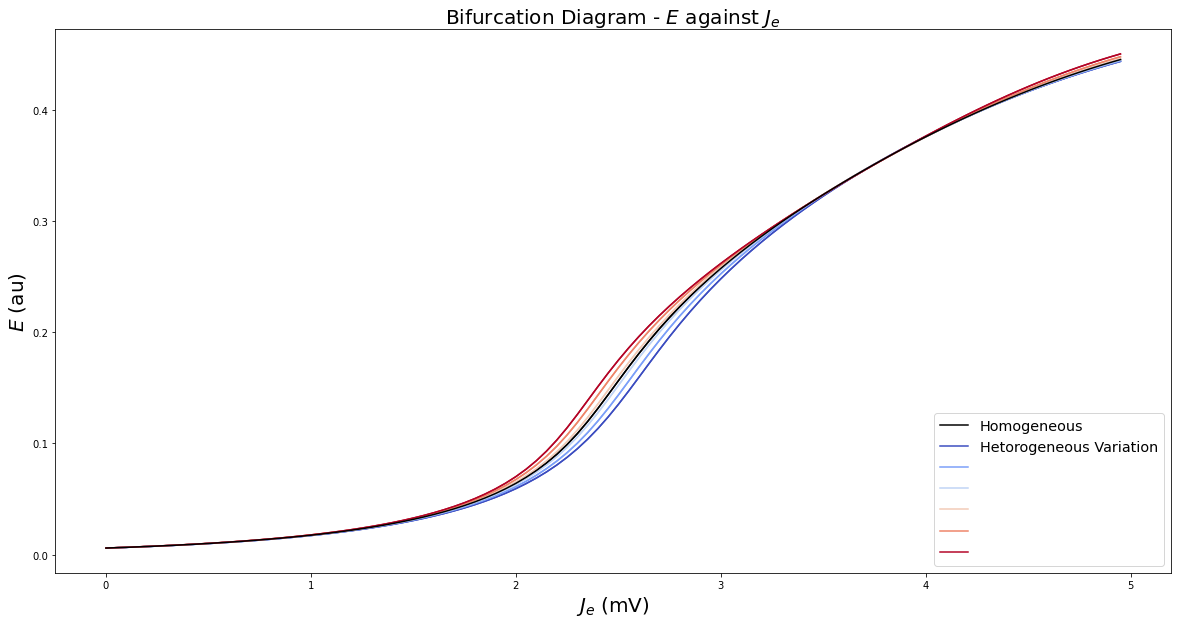

In [88]:
#R_i = 0

Regions = 6

# Scaling Term:
R_e = np.linspace(-0.1,0.1,num=Regions)
#R_i = -np.linspace(-0.1,0.1,num=Regions)
R_i = np.zeros(Regions)

h_c_ee =  W_ee * (1 + R_e) 
h_c_ei = W_ei * (1 + R_i) 
h_c_ie = W_ie * (1 + R_e) 
h_c_ii = W_ii * (1 + R_i) 

# Simulate Het BIfurcation Diagrams

AllRuns_max = []
AllRuns_min = []

for i in np.arange(len(h_c_ee)):
    The_max = []
    The_min = []

    # Parameters
    w_ee=h_c_ee[i]
    w_ei=h_c_ei[i]
    w_ie=h_c_ie[i]
    w_ii=h_c_ii[i]

    # Integrator Settings
    length = 10000 
    dt = 0.1
    t = np.arange(0, length, dt)
    J = np.arange(0,5,0.05)

    for J_e in J:
        # Solve it! Note that the additional "args" supplied to "odeint" must be in a tuple; "(a,)".
        solut = odeint(func, [0.5, 0.5], t, args=(J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,tau_i) )

        # Obtain the max and min of the last 1/10 (tenth) elements
        eqbm_max = max(solut[-int(length/dt/10):,0])
        eqbm_min = min(solut[-int(length/dt/10):,0])

        The_max.append(eqbm_max)
        The_min.append(eqbm_min)

    AllRuns_max.append(The_max)
    AllRuns_min.append(The_min)

# Plot.

jet= plt.get_cmap('coolwarm')
colors = jet(np.linspace(0,1,Regions))

plt.plot(J,Homog_max,color='k')
for i in np.arange(len(h_c_ee)):
    plt.plot(J,AllRuns_max[i],color=colors[i],)   

for i in np.arange(len(h_c_ee)):
     plt.plot(J,AllRuns_min[i],color=colors[i],)



plt.plot(J,Homog_min,color='k')  

plt.xlabel("$J_e$ (mV)", fontsize=20)
plt.ylabel("$E$ (au)", fontsize=20)
plt.title("Bifurcation Diagram - $E$ against $J_e$", fontsize=20)
plt.legend(("Homogeneous","Hetorogeneous Variation","","","","",""),loc="lower right",fontsize="x-large")
plt.show()


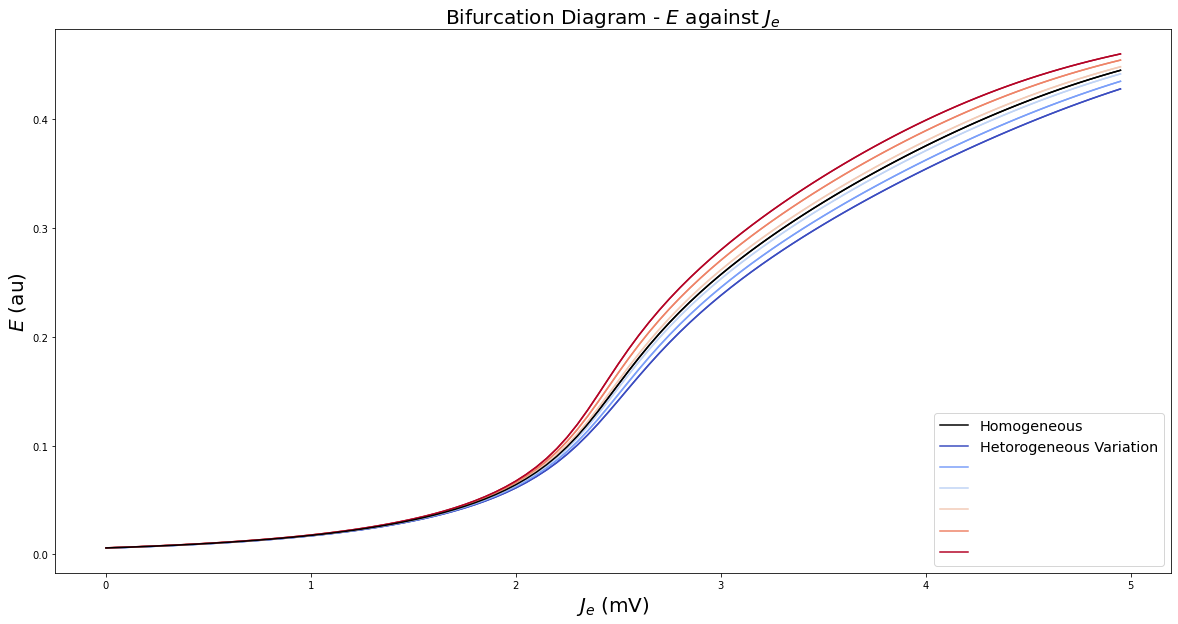

In [89]:
# R_e = 0 

Regions = 6

# Scaling Term:
#R_e = np.linspace(-0.1,0.1,num=Regions)
R_i = -np.linspace(-0.1,0.1,num=Regions)
R_e = np.zeros(Regions)

h_c_ee =  W_ee * (1 + R_e) 
h_c_ei = W_ei * (1 + R_i) 
h_c_ie = W_ie * (1 + R_e) 
h_c_ii = W_ii * (1 + R_i) 

# Simulate Het BIfurcation Diagrams

AllRuns_max = []
AllRuns_min = []

for i in np.arange(len(h_c_ee)):
    The_max = []
    The_min = []

    # Parameters
    w_ee=h_c_ee[i]
    w_ei=h_c_ei[i]
    w_ie=h_c_ie[i]
    w_ii=h_c_ii[i]

    # Integrator Settings
    length = 10000 
    dt = 0.1
    t = np.arange(0, length, dt)
    J = np.arange(0,5,0.05)

    for J_e in J:
        # Solve it! Note that the additional "args" supplied to "odeint" must be in a tuple; "(a,)".
        solut = odeint(func, [0.5, 0.5], t, args=(J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,tau_i) )

        # Obtain the max and min of the last 1/10 (tenth) elements
        eqbm_max = max(solut[-int(length/dt/10):,0])
        eqbm_min = min(solut[-int(length/dt/10):,0])

        The_max.append(eqbm_max)
        The_min.append(eqbm_min)

    AllRuns_max.append(The_max)
    AllRuns_min.append(The_min)

# Plot.

jet= plt.get_cmap('coolwarm')
colors = jet(np.linspace(0,1,Regions))

plt.plot(J,Homog_max,color='k')
for i in np.arange(len(h_c_ee)):
    plt.plot(J,AllRuns_max[i],color=colors[i],)   

for i in np.arange(len(h_c_ee)):
     plt.plot(J,AllRuns_min[i],color=colors[i],)



plt.plot(J,Homog_min,color='k')  

plt.xlabel("$J_e$ (mV)", fontsize=20)
plt.ylabel("$E$ (au)", fontsize=20)
plt.title("Bifurcation Diagram - $E$ against $J_e$", fontsize=20)
plt.legend(("Homogeneous","Hetorogeneous Variation","","","","",""),loc="lower right",fontsize="x-large")
plt.show()


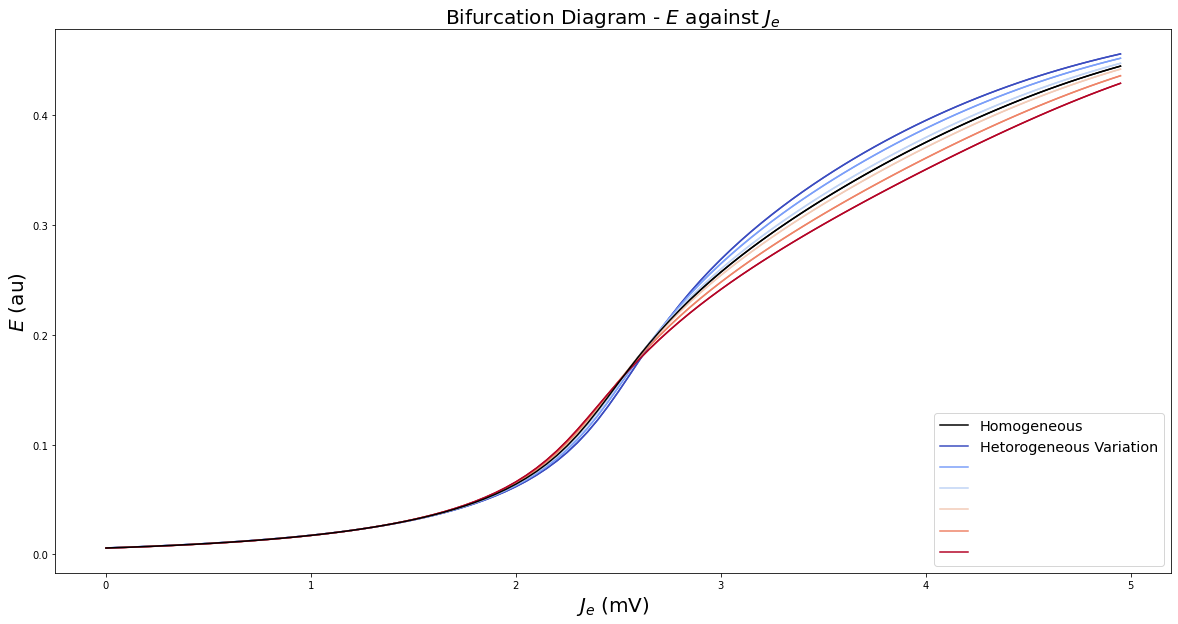

In [90]:
# R_e = R_i

Regions = 6

# Scaling Term:
R_e = np.linspace(-0.1,0.1,num=Regions)
R_i = np.linspace(-0.1,0.1,num=Regions)
#R_e = np.zeros(Regions)

h_c_ee =  W_ee * (1 + R_e) 
h_c_ei = W_ei * (1 + R_i) 
h_c_ie = W_ie * (1 + R_e) 
h_c_ii = W_ii * (1 + R_i) 

# Simulate Het BIfurcation Diagrams

AllRuns_max = []
AllRuns_min = []

for i in np.arange(len(h_c_ee)):
    The_max = []
    The_min = []

    # Parameters
    w_ee=h_c_ee[i]
    w_ei=h_c_ei[i]
    w_ie=h_c_ie[i]
    w_ii=h_c_ii[i]

    # Integrator Settings
    length = 10000 
    dt = 0.1
    t = np.arange(0, length, dt)
    J = np.arange(0,5,0.05)

    for J_e in J:
        # Solve it! Note that the additional "args" supplied to "odeint" must be in a tuple; "(a,)".
        solut = odeint(func, [0.5, 0.5], t, args=(J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,tau_i) )

        # Obtain the max and min of the last 1/10 (tenth) elements
        eqbm_max = max(solut[-int(length/dt/10):,0])
        eqbm_min = min(solut[-int(length/dt/10):,0])

        The_max.append(eqbm_max)
        The_min.append(eqbm_min)

    AllRuns_max.append(The_max)
    AllRuns_min.append(The_min)

# Plot.

jet= plt.get_cmap('coolwarm')
colors = jet(np.linspace(0,1,Regions))

plt.plot(J,Homog_max,color='k')
for i in np.arange(len(h_c_ee)):
    plt.plot(J,AllRuns_max[i],color=colors[i],)   

for i in np.arange(len(h_c_ee)):
     plt.plot(J,AllRuns_min[i],color=colors[i],)



plt.plot(J,Homog_min,color='k')  

plt.xlabel("$J_e$ (mV)", fontsize=20)
plt.ylabel("$E$ (au)", fontsize=20)
plt.title("Bifurcation Diagram - $E$ against $J_e$", fontsize=20)
plt.legend(("Homogeneous","Hetorogeneous Variation","","","","",""),loc="lower right",fontsize="x-large")
plt.show()


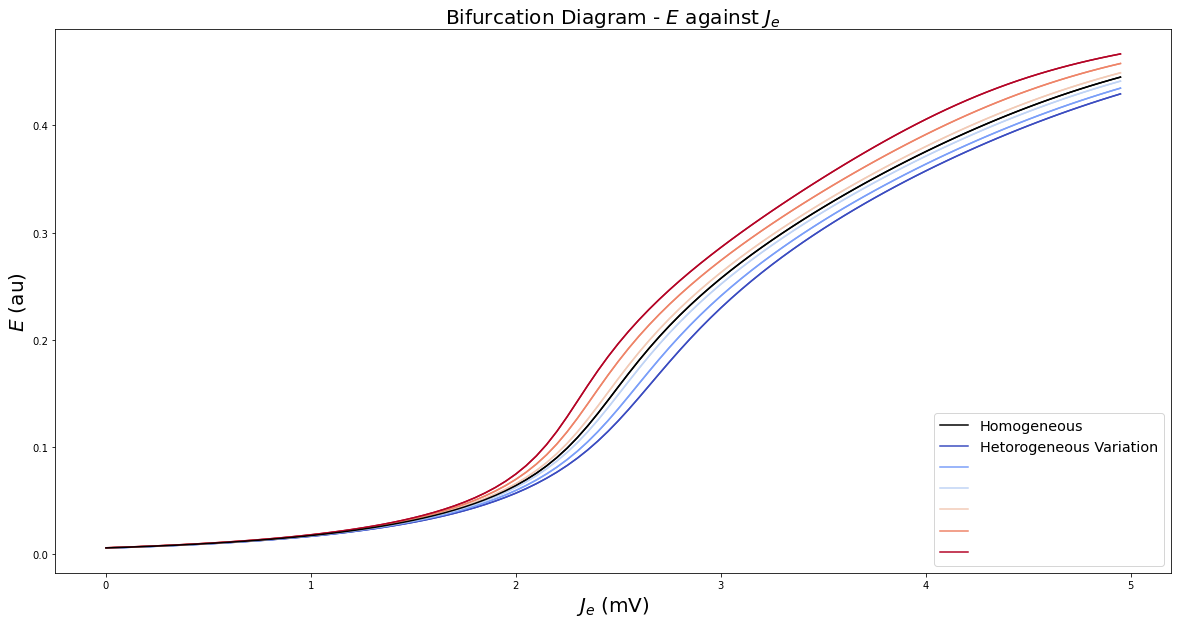

In [91]:
# R_e = -R_i

Regions = 6

# Scaling Term:
R_e = np.linspace(-0.1,0.1,num=Regions)
R_i = -np.linspace(-0.1,0.1,num=Regions)
#R_e = np.zeros(Regions)

h_c_ee =  W_ee * (1 + R_e) 
h_c_ei = W_ei * (1 + R_i) 
h_c_ie = W_ie * (1 + R_e) 
h_c_ii = W_ii * (1 + R_i) 

# Simulate Het BIfurcation Diagrams

AllRuns_max = []
AllRuns_min = []

for i in np.arange(len(h_c_ee)):
    The_max = []
    The_min = []

    # Parameters
    w_ee=h_c_ee[i]
    w_ei=h_c_ei[i]
    w_ie=h_c_ie[i]
    w_ii=h_c_ii[i]

    # Integrator Settings
    length = 10000 
    dt = 0.1
    t = np.arange(0, length, dt)
    J = np.arange(0,5,0.05)

    for J_e in J:
        # Solve it! Note that the additional "args" supplied to "odeint" must be in a tuple; "(a,)".
        solut = odeint(func, [0.5, 0.5], t, args=(J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,tau_i) )

        # Obtain the max and min of the last 1/10 (tenth) elements
        eqbm_max = max(solut[-int(length/dt/10):,0])
        eqbm_min = min(solut[-int(length/dt/10):,0])

        The_max.append(eqbm_max)
        The_min.append(eqbm_min)

    AllRuns_max.append(The_max)
    AllRuns_min.append(The_min)

# Plot.

jet= plt.get_cmap('coolwarm')
colors = jet(np.linspace(0,1,Regions))

plt.plot(J,Homog_max,color='k')
for i in np.arange(len(h_c_ee)):
    plt.plot(J,AllRuns_max[i],color=colors[i],)   

for i in np.arange(len(h_c_ee)):
     plt.plot(J,AllRuns_min[i],color=colors[i],)



plt.plot(J,Homog_min,color='k')  

plt.xlabel("$J_e$ (mV)", fontsize=20)
plt.ylabel("$E$ (au)", fontsize=20)
plt.title("Bifurcation Diagram - $E$ against $J_e$", fontsize=20)
plt.legend(("Homogeneous","Hetorogeneous Variation","","","","",""),loc="lower right",fontsize="x-large")
plt.show()


Hysteresis is a pain and edemands to be special

In [9]:
def sig(v):
    # Sigmoid function
    return 1/(1 + np.exp(-v))

# Fixed pt - J_i=0,b_e=3,b_i=3.7,a_e=1,a_i=1,w_ee=12,w_ei=15,w_ie=10,w_ii=8,
# LCycle - J_i=0,b_e=2,b_i=2.8,a_e=1,a_i=1,w_ee=11,w_ei=10,w_ie=10,w_ii=1,
# LCycleH - J_i=0,b_e=3,b_i=4,a_e=1.3,a_i=2,w_ee=16,w_ei=12,w_ie=15,w_ii=3,
# Jump - J_i=0,b_e=5,b_i=3.7,a_e=1.3,a_i=2,w_ee=11,w_ei=10,w_ie=10,w_ii=1,


#def func(z,J_e,J_i,b_e,b_i,a_e,a_i,w_ee,w_ei,w_ie,w_ii,tau_e,_tau_i):
def func(z,J_e,J_i=0,b_e=5,b_i=5.5,a_e=1.3,a_i=2,w_ee=11,w_ei=10,w_ie=10,w_ii=1,):
    # Initialise the function array.
    f = np.zeros(2)

    E = z[0]
    I = z[1]

    # Wilson Cowan Equations setting derivative = 0 
    f[0] = -E + (1 - E)*sig(a_e*(w_ee*E - w_ei*I - b_e + J_e))
    f[1] = -I + (1 - I)*sig(a_i*(w_ie*E - w_ii*I - b_i + J_i))

    return f

In [12]:
J_e = np.arange(0,5,0.05)
array = []
array_3 = []

for i in J_e:
    
    array_2 = []

    for j in np.arange(100):
        # Brute force try random ones:
        sol = fsolve(func,[random.random()/2,random.random()/2],i,maxfev=100000,)
        # func(root) should be almost 0.0.
        if all(np.isclose(func(sol,i), [0.0, 0.0])):
            # Get only E value
            array_2.append(sol[0])
        else:
            array_2.append(np.nan)    

    # Then add the median, max, and min to the end of array

    array_3.append(array_2)


array_3 = np.array(array_3)

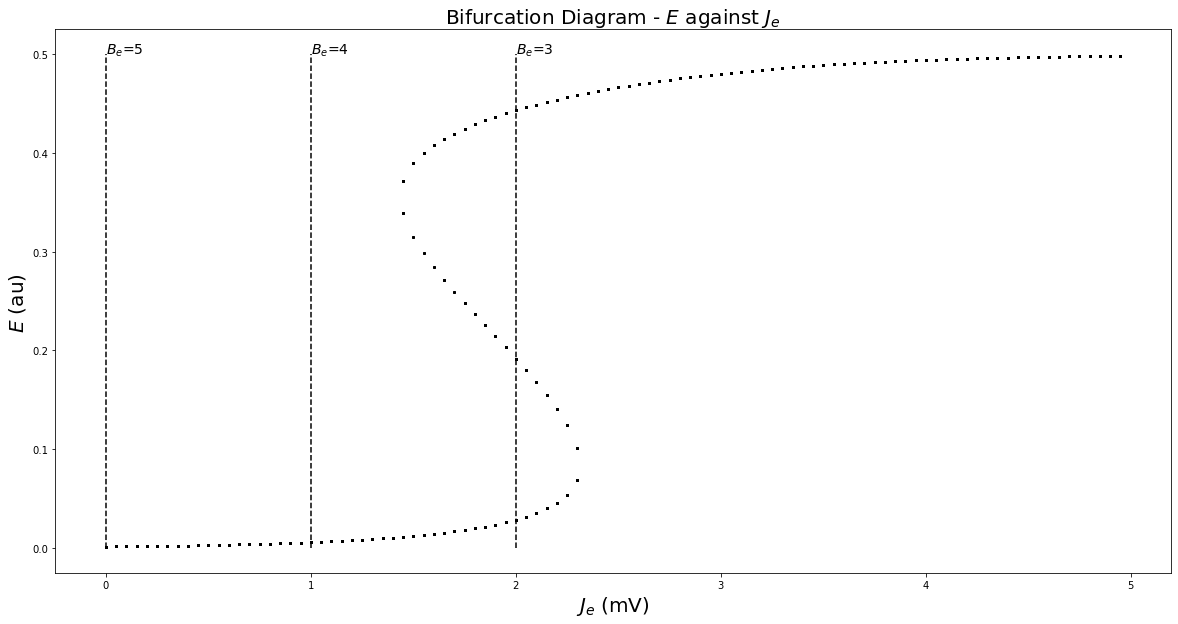

In [13]:
plt.plot(J_e,array_3,'k.',markersize=3)

#plt.legend(('Stable','Unstable'),title="Equilibrium",loc="lower right",title_fontsize="x-large",fontsize="x-large")

plt.vlines(x=0,ymin=0,ymax=0.5,colors='k',linestyles='dashed')
plt.text(0,0.5,"$B_e$=5",fontsize=14)

plt.vlines(x=1,ymin=0,ymax=0.5,colors='k',linestyles='dashed')
plt.text(1,0.5,"$B_e$=4",fontsize=14)

plt.vlines(x=2,ymin=0,ymax=0.5,colors='k',linestyles='dashed')
plt.text(2,0.5,"$B_e$=3",fontsize=14)

#plt.vlines(x=3,ymin=0,ymax=0.5,colors='k',linestyles='dashed')
#plt.text(3,0.5,"$B_e$=0",fontsize=14)

plt.xlabel("$J_e$ (mV)", fontsize=20)
plt.ylabel("$E$ (au) ", fontsize=20)
plt.title("Bifurcation Diagram - $E$ against $J_e$", fontsize=20)
plt.show()
